# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [25]:
# Imports

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

## Part 1 - Importing Datasets

### Part (a) - Parsing Data into Pandas

In [2]:
# Prepare for import

raw_datasets = []
raw_datasets_np = []

dataset_paths = glob.glob('imu_data/Sensor_*')
N_DATASETS = len(dataset_paths)

dataset_paths

['imu_data/Sensor_record_20190429_173940_grass.csv',
 'imu_data/Sensor_record_20190429_173526_sidewalk.csv',
 'imu_data/Sensor_record_20190429_173109_gravel.csv',
 'imu_data/Sensor_record_20190429_172255_concrete.csv',
 'imu_data/Sensor_record_20190429_172846_asphalt.csv']

In [3]:
# Import datasets as an array of Pandas DataFrames

TRIM_LEN = 2000 # Number of data points to trim from each side
N_DATA_COL = 6 # Number of columns containing directional data

dataset_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Time']
dataset_labels = []

for dataset_path in dataset_paths:
    # Parse labels
    dataset_labels.append(dataset_path.split('_')[-1].split('.')[0].capitalize())
    
    # Read from CSV
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused paramaters
    dataset = dataset.drop(['YYYY-MO-DD HH-MI-SS_SSS', 'ACCELEROMETER X (m/s²)',
                            'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)'], axis=1)
    dataset.columns = dataset_columns
    
    # Trim edges to account for startup time
    dataset = dataset[TRIM_LEN:-TRIM_LEN]
   
    raw_datasets.append(dataset)

# Print some useful information
print('Labels: {}'.format(dataset_labels))
raw_datasets[0].head(n=20)

Labels: ['Grass', 'Sidewalk', 'Gravel', 'Concrete', 'Asphalt']


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Time
2000,0.69,1.78,0.57,0.27,0.00,0.17,10005
2001,0.69,1.78,0.57,0.27,0.00,0.17,10011
2002,-0.94,1.51,0.11,0.38,0.02,0.16,10016
2003,-0.94,1.51,0.11,0.38,0.02,0.16,10020
2004,-0.94,1.51,0.11,0.38,0.02,0.16,10025
2005,-0.94,1.51,0.11,0.38,0.02,0.16,10032
2006,-0.94,1.51,0.11,0.38,0.02,0.16,10035
2007,-0.94,1.51,0.11,0.38,0.02,0.16,10040
2008,-0.94,1.51,0.11,0.38,0.02,0.16,10045
2009,-0.94,1.51,0.11,0.38,0.02,0.16,10050


It looks like the update rate of the IMU is non deterministic and lower than the rate the phone samples it at, i.e. the phone receives a non-deterministic number of sequential identical measurements from the IMU when polling at approx 200 Hz.

### Part (b) - Visualizing Time Domain Data

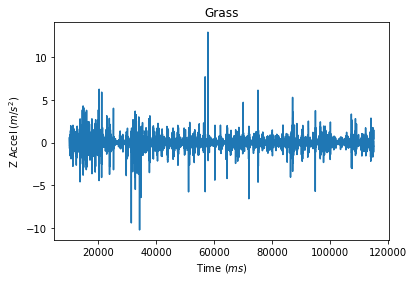

In [4]:
# Plot an example dataset

plt.plot(raw_datasets[0]['Time'], raw_datasets[0]['Z Accel'])
plt.xlabel('Time ($ms$)')
plt.ylabel('Z Accel ($m/s^2$)')
plt.title('Grass')
plt.show()

In [5]:
'''Plot given x annd y axes for every dataset in given array of datasets'''
def plot_all(n_datasets, labels, x_axis, y_axis, x_unit='($ms$)', y_unit='($m/s^2$)'):
    plt.clf()
    
    n_axes = len(n_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i in range(n_axes):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        axes[i].plot(n_datasets[i][x_axis], n_datasets[i][y_axis])
        axes[i].set_title(labels[i])
        axes[i].set_xlabel(x_axis + ' ' + x_unit)
        axes[i].set_ylabel(y_axis + ' ' + y_unit)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

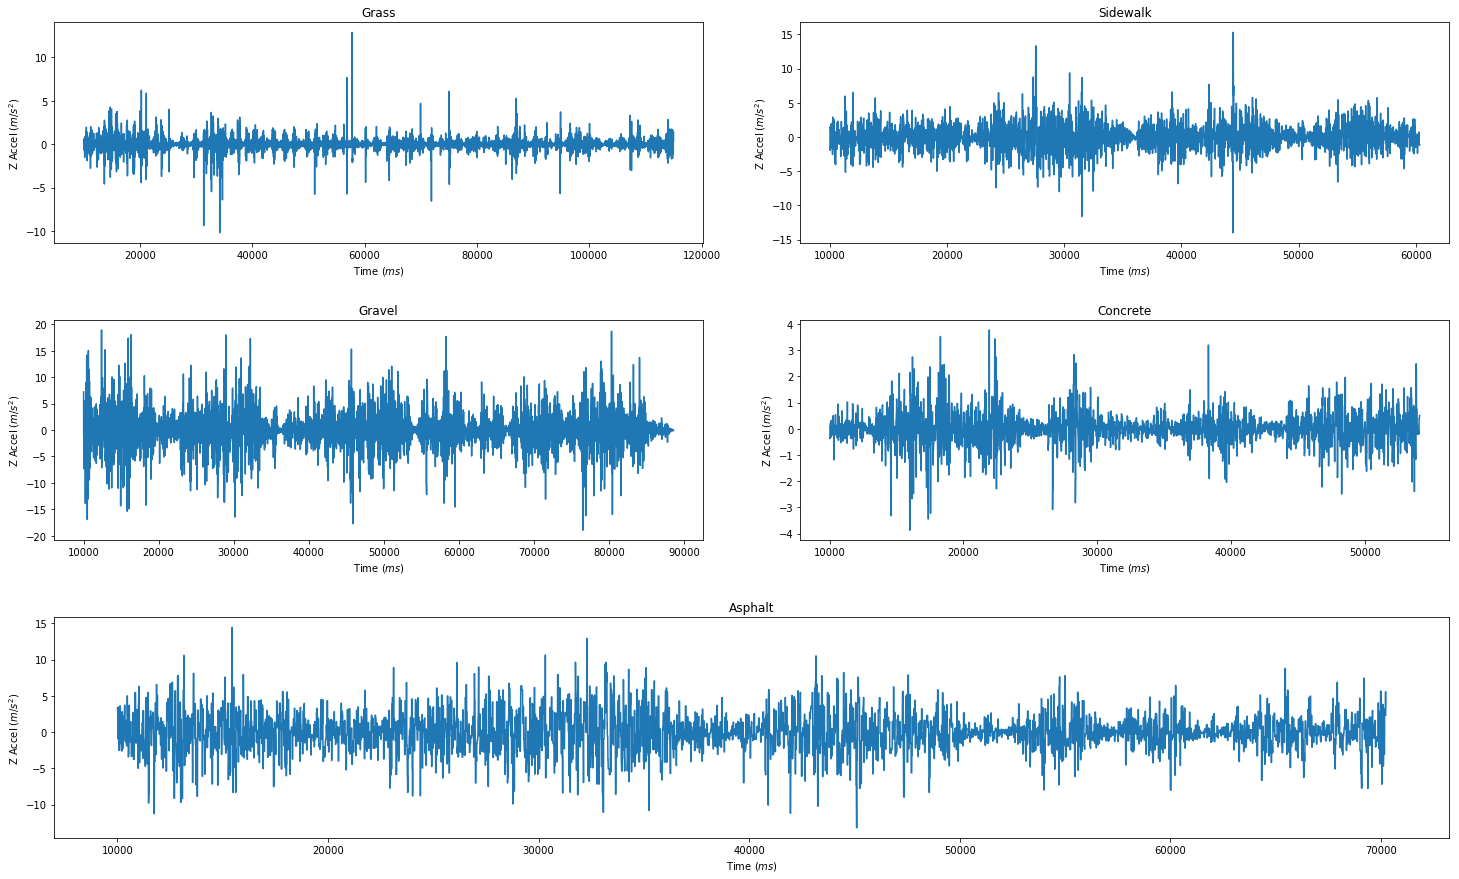

In [6]:
# Plot some examples
plot_all(raw_datasets, dataset_labels, x_axis='Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [7]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets):
    np_datasets = []
    
    for dataset in pd_datasets:
        np_datasets.append(dataset.as_matrix())
    
    return np_datasets

In [8]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets):
    pd_datasets = []
    
    for dataset in np_datasets:
        pd_datasets.append(pd.DataFrame(data=dataset, columns=dataset_columns))
    
    return pd_datasets

In [9]:
# Convert to NumPy
raw_datasets_np = pd_to_np(raw_datasets)

# Check if its constructed correctly
print('Num datasets: {}'.format(len(raw_datasets_np)))
print('Shape of first dataset: {}'.format(raw_datasets_np[0].shape))

Num datasets: 5
Shape of first dataset: (20998, 7)


## Part 2 - Filtering

Datasheets of smartphone level IMUs suggest that IMU filters data before sending it to the phone, and that the cutoff frequency of this filtering is configurable and changes with update frequency.

Based on the IMU update rate of about 20 ms, this cutoff frequency is already close to 40 Hz, so filtering is probably unnecessary. Its hard to be sure about actual values because this is configured by the phone manufacturer.

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

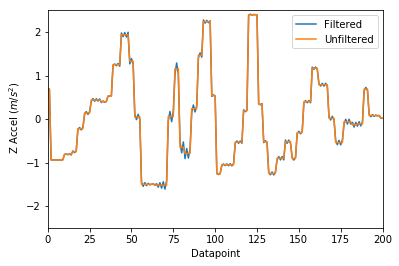

In [10]:
datasets = [] # Filtered data 
datasets_np = []

F_SAMP = 200 # Sampling frequency
F_CUT = 95 # Cutoff frequency

w = F_CUT / (F_SAMP / 2) # Normalize the frequency

# Get Butterworth filter parameters
b_butter, a_butter = signal.butter(N=4, Wn=w, btype='low')

# Filter each data column of every dataset
for dataset in raw_datasets_np: # Make a copy first
    datasets_np.append(np.copy(dataset))

for dataset in datasets_np:
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:,i])

# Compare filtered and unfiltered
plt.clf()
plt.plot(datasets_np[0][:, 0], label='Filtered')
plt.plot(raw_datasets_np[0][:, 0], label='Unfiltered')
plt.xlim(0, 200)
plt.ylim(-2.5, 2.5)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel(' Z Accel ($m/s^2$)')
plt.show()

In [11]:
# Check construction
print('Num filtered datasets: {}'.format(len(datasets_np)))
print('Shape of first filtered dataset: {}'.format(datasets_np[0].shape))

Num filtered datasets: 5
Shape of first filtered dataset: (20998, 7)


In [12]:
# Convert back to Pandas
datasets = np_to_pd(datasets_np)
datasets[0].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Time
0,0.691654,1.781494,0.563160,0.270195,0.000186,0.169996,10005.0
1,0.688196,1.782751,0.577607,0.269114,-0.000543,0.169993,10011.0
2,-0.938239,1.502808,0.101593,0.381540,0.020883,0.160006,10016.0
3,-0.941499,1.521802,0.119228,0.377854,0.018799,0.160008,10020.0
4,-0.939002,1.493450,0.099943,0.382695,0.021490,0.159966,10025.0


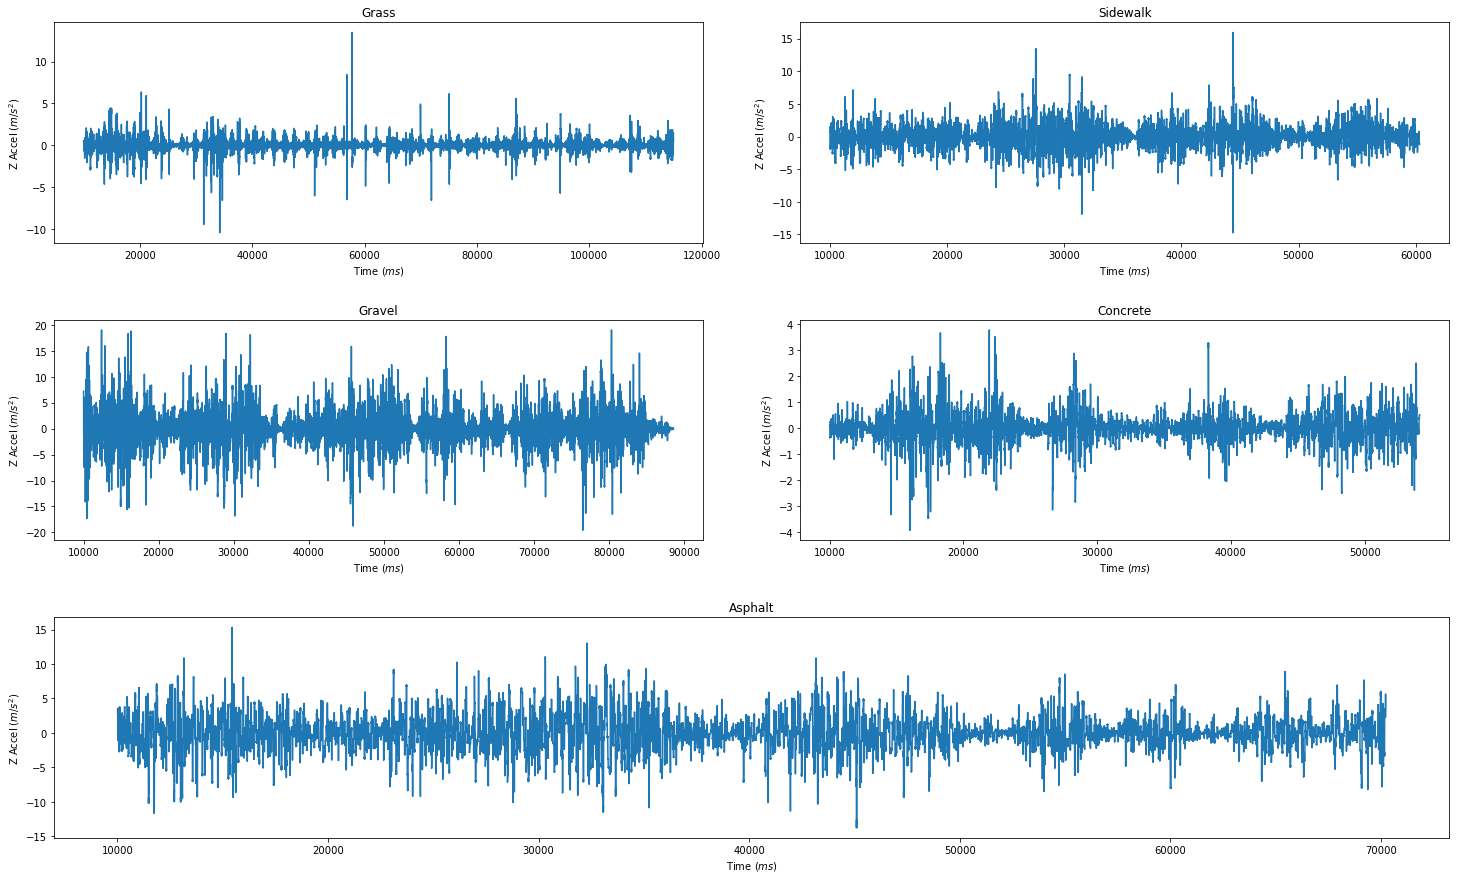

In [13]:
# Plot all filtered datasets
plot_all(datasets, dataset_labels, x_axis='Time', y_axis='Z Accel')

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [14]:
WINDOW_SIZE = 1000 # Divide by 200 to get sample size in seconds
datasets_np_windowed = []

# Trim excess datapoints, then split into windows
for dataset in datasets_np:   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, N_DATA_COL + 1,))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_np_windowed.append(dataset_windowed)

In [15]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_np_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_np_windowed[0])))
print('Shape of individual window: {}'.format(datasets_np_windowed[0][0].shape))

Num windowed datasets: 5
Num of windows in first dataset: 20
Shape of individual window: (1000, 7)


Structure of the data right now:

`1D Array containing each dataset -> 1D Array containg each window -> 2D NP Array of actual data for each sensor`

## Part 4 - FFT and PSD

### Part (a) - FFT
Its possible the FFT is not valid due to the non determinisitic update rate. Probably needs some interpolation.

In [16]:
datasets_np_fft = []

# Find the FFT of each column of each data window of each dataset
for dataset in datasets_np_windowed:
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        
        # Trim and add a new column for frequency
        window_fft = np.resize(window, (n_bins, window.shape[1] + 1))
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between datasets
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i], axis=0), n_bins)), n_bins)
            
        # Append the frequency column
        window_fft[:, N_DATA_COL + 1] = np.linspace(0.0, F_SAMP / 2, n_bins)
        
        dataset_fft.append(window_fft)
        
    datasets_np_fft.append(dataset_fft)

In [17]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_np_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_np_fft[0])))
print('Shape of FFT\'d individual window: {}'.format(datasets_np_fft[0][0].shape))

Num of FFT'd windowed datasets: 5
Num of FFT'd windows in first dataset: 20
Shape of FFT'd individual window: (500, 8)


In [18]:
'''Plot FFT in given direction and window'''
def plot_set_ffts(dirn, win=0):
    plt.clf()
    plt.figure(figsize=(8, 6))

    for i in range(N_DATASETS):
        plt.plot(datasets_np_fft[i][win][:, N_DATA_COL+1], datasets_np_fft[i][win][:, dirn], label=dataset_labels[i])

    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Amplitude (Normalized to Window Size)')
    plt.title('FFT of ' + dataset_columns[dirn] + ', Window {}, Window Size {} Data Points'.format(win, WINDOW_SIZE))
    plt.legend()
    plt.show()

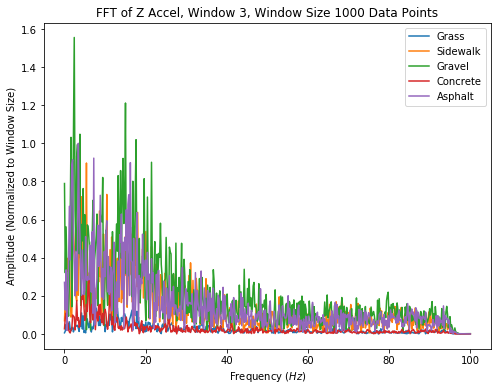

In [19]:
# Plot Z Accel of 3rd window
plot_set_ffts(2, 3)

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on sample size**

### Part (b) - PSD

In [20]:
datasets_np_psd = []

# Find the PSD of each column of each data window of each dataset
for dataset in datasets_np_windowed:
    dataset_psd = []
    
    for window in dataset:
        # Add a new column for freq
        window_psd = np.resize(window, (int(WINDOW_SIZE / 2), window.shape[1] + 1))
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], F_SAMP)
            window_psd[:, i] = np.resize(Pxx[1:], int(WINDOW_SIZE / 2))
            
        # Append freq column
        window_psd[:, N_DATA_COL + 1] = freq[:-1]
        
        dataset_psd.append(window_psd)
        
    datasets_np_psd.append(dataset_psd)

In [21]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_np_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_np_psd[0])))
print('Shape of PSD\'d individual window: {}'.format(datasets_np_psd[0][0].shape))

Num PSD'd windowed datasets: 5
Num of PSD'd windows in first dataset: 20
Shape of PSD'd individual window: (500, 8)


In [22]:
'''Plot PSD in given direction and window'''
def plot_set_psds(dirn, win=0):
    plt.clf()
    plt.figure(figsize=(8, 6))

    for i in range(N_DATASETS):
        plt.semilogy(datasets_np_psd[i][win][:, N_DATA_COL + 1], datasets_np_psd[i][win][:, dirn], 
                     label=dataset_labels[i])
    
    plt.legend()
    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Amplitude ($m/s^2$ or $rad/s$)')
    plt.title('PSD of ' + dataset_columns[dirn] + ', Window {}, Window Size {} Data Points'.format(win, WINDOW_SIZE))
    plt.show()

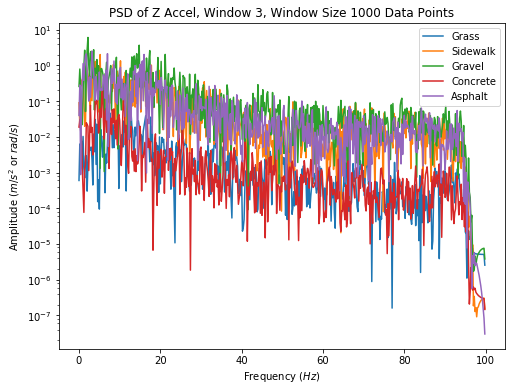

In [23]:
# Plot Z Accel of 3rd window
plot_set_psds(2, 3)

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array (6 cols FFT/PSD in one direction, col 7 is time, col 8 is freq)`

### Part (c) - 3D Visualization

 - FFT in 3d for each terrain

 - Spectogram for each terrain

In [45]:
'''Plot the set ffts in 3d'''
def plot_set_ffts_3d(dirn, win=0):
    plt.clf()
    fig = plt.figure(figsize=(12, 10))
    ax = fig.gca(projection='3d')

    ax.set_ylim(0, 4)
    ax.set_zlim(0, 2)
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_ylabel('Dataset Number')
    ax.set_zlabel('Amplitude (Normalized)')
    
    # Plot each dataset FFT
    for i in range(N_DATASETS):
        ax.plot(xs=datasets_np_fft[i][win][:, N_DATA_COL+1], ys=datasets_np_fft[i][win][:, dirn], 
                zs=i, zdir='y', label=dataset_labels[i])
        
    ax.legend()
    plt.show()

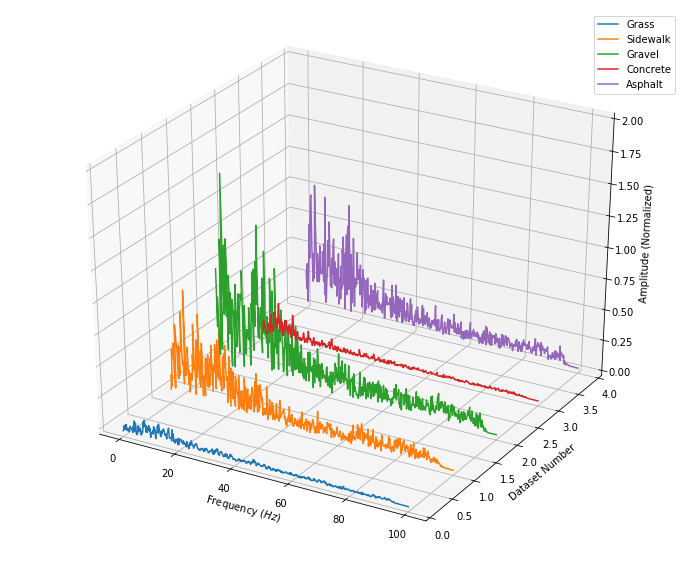

In [46]:
# Plot Z Accel of 3rd window
plot_set_ffts_3d(2, 3)

## Part 5 - Feature Extraction

Data storage of features:

`Labelled Terrain Dataset -> Direction -> Array with elements extracted from each time window, row = window #, col = feature`

In [ ]:
# Some feature extraction functions needed

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    return num / denom

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    return num / denom

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [ ]:
'''Extract given features from everything in dataset'''
def feature_all(feat_funcs, feat_names, datasets, regular=True):
    datasets_feat = []
    
    # Calculate features for each window of each column of each dataset
    for dataset in datasets:
        directions = []

        for i in range(N_DATA_COL):
            feats = []
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))

                    # Already append to features array
                    feats.append(feat_in_window)
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    for window in dataset:
                        feat_in_window.append(function(window[:, N_DATA_COL+1], window[:, i]))
                    
                    feats.append(feat_in_window)
                    
            # Execute every function over all windows    
            for func in feat_funcs:
                function_all_windows(func)

            directions.append(np.transpose(np.array(feats)))

        datasets_feat.append(directions)
    
    return datasets_feat

In [ ]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, feat_names, dirn=0, feat=0):
    plt.clf()
    plt.figure(figsize=(8,6))
    
    for i in range(N_DATASETS):
        plt.plot(datasets_feat[i][dirn][:, feat], label=dataset_labels[i])
        
    plt.ylabel(feat_names[feat])
    plt.xlabel('Window #')
    plt.title(dataset_columns[dirn] + ', Window Size {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [ ]:
# Time domain feature function names and actual names
time_feat_funcs = [np.mean, np.std, l2norm, autocorr, np.amax, np.amin, rms, zcr, stats.skew, stats.kurtosis]
time_feat_names = ['Mean', 'Std Dev', 'L2 Norm', 'Autocorrelation', 'Max', 'Min', 'Root Mean Squared',
                   'Zero Crossing Rate', 'Skew', 'Excess Kurtosis']

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_feat_funcs, time_feat_names, datasets_np_windowed)

In [ ]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[0])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[0][0].shape))

In [ ]:
# Plot Max of Z Accel
plot_set_features(datasets_feat_time, time_feat_names, 3, 4)

### Part (b) - Frequency Domain Features

In [ ]:
# Time domain feature function names and actual names
freq_feat_funcs = [msf, rmsf, fc, vf, rvf]
freq_feat_names = ['Mean Square Frequency', 'Root Mean Square Frequency', 'Frequency Center', 'Variance Frequency',
                   'Root Variance Frequency']

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_feat_funcs, freq_feat_names, datasets_np_psd, regular=False)

In [ ]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[0])))
print('Shape of one direction: {}'.format(datasets_feat_freq[0][0].shape))

In [ ]:
# Plot RVF of Z Accel
plot_set_features(datasets_feat_freq, freq_feat_names, 2, 4)

Lots of very similar shapes i.e. highly correlated variables in both time and frequency. Need to implement feature selection.

**Ideally we can implement feature selection over all directions, with FFT + PSD + Time Features + Freq Features**

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$